In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import os
from fonctions import *

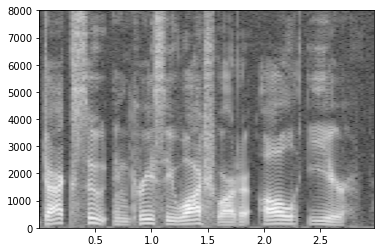

In [44]:
waveform, sample_rate = torchaudio.load("../Data/meme_taille_TEST/sig_1_10.WAV")
spec_br, f_br, t_br, im_br = plt.specgram(waveform[0].t().numpy(), Fs = sample_rate, NFFT = 512, scale_by_freq = True, mode = 'psd', cmap = 'gray')

In [3]:
######################### MEME TAILLE DE SIGNAUX

"""taille_sig("../Data/speech_TEST/TIMIT_TEST/DR1")
taille_sig("../Data/speech_TEST/TIMIT_TEST/DR2")
taille_sig("../Data/speech_TEST/TIMIT_TEST/DR3")
taille_sig("../Data/speech_TEST/TIMIT_TEST/DR4")
taille_sig("../Data/speech_TEST/TIMIT_TEST/DR5")
taille_sig("../Data/speech_TEST/TIMIT_TEST/DR6")
taille_sig("../Data/speech_TEST/TIMIT_TEST/DR7")
taille_sig("../Data/speech_TEST/TIMIT_TEST/DR8")"""

'taille_sig("../Data/speech_TEST/TIMIT_TEST/DR1")\ntaille_sig("../Data/speech_TEST/TIMIT_TEST/DR2")\ntaille_sig("../Data/speech_TEST/TIMIT_TEST/DR3")\ntaille_sig("../Data/speech_TEST/TIMIT_TEST/DR4")\ntaille_sig("../Data/speech_TEST/TIMIT_TEST/DR5")\ntaille_sig("../Data/speech_TEST/TIMIT_TEST/DR6")\ntaille_sig("../Data/speech_TEST/TIMIT_TEST/DR7")\ntaille_sig("../Data/speech_TEST/TIMIT_TEST/DR8")'

In [43]:
####################### SIGNAUX NON BRUITÉS

# for subdir, dirs, files in os.walk("../Data/meme_taille_TEST"):
#     for file in files:
#             subpath = os.path.join(subdir, file)
#             waveform, sample_rate = torchaudio.load(subpath)
#             spec, f, t, im = plt.specgram(waveform[0].t().numpy(), Fs = sample_rate, NFFT = 512, scale_by_freq = True, mode = 'psd', cmap = 'gray')
            
#             #on ajoute le spectro au dossier
             
#             path_list = subpath.split("/")
#             br_name = 'nb_' + path_list[3][:-3] + 'npy'

#             np.save('../Data/sig/non_bruité/' + br_name, spec.astype(np.float32))

            
######################## BRUITAGE DES SIGNAUX

# RSB = input('entrer le RSB voulu')
# bruit, sample_rate_bruit = torchaudio.load("../Data/babble.wav")
# bruit_rs = torchaudio.transforms.Resample(sample_rate_bruit, 16000)(bruit)
# for subdir, dirs, files in os.walk("../Data/meme_taille_TEST"):
#     for file in files:
#         if ('.WAV' in file):
#             subpath = os.path.join(subdir, file)
#             save_bruit(subpath, bruit, bruit_rs, RSB)
   

In [1]:
############################### MISE EN PLACE DU CNN
import torch
from torch.autograd import Variable
from torch.optim import Adam, SGD

import torch.nn as nn
import torch.optim as optim

batch_size = 5
epochs = 20
learning_rate = 1e-3

In [2]:
############################## CRÉATION DU DATASET

import torch
import torchvision
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import torchaudio
import numpy as np
import matplotlib.image as mpimg
from torch import tensor
import os
from torchvision.transforms import ToTensor
from PIL import Image 

def my_loader(filename):
    return np.load(filename)
    
data = torchvision.datasets.DatasetFolder('../Data/test/Dataset', transform = ToTensor(), loader = my_loader, extensions = '.npy')
# data = torchvision.datasets.DatasetFolder('../Data/test', transform = None, loader = my_loader, extensions = '.npy')

test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

In [3]:
import torch.nn as nn
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer1 = nn.Conv2d(
            in_channels=1, out_channels=10, kernel_size=(15, 15)
        )
        self.encoder_hidden_layer2 = nn.Conv2d(
            in_channels=10, out_channels=20, kernel_size=(15, 15)
        )
        self.poolp = nn.MaxPool2d(
            kernel_size=2, padding=(1,1)
        )
        self.pool = nn.MaxPool2d(
            kernel_size=2
        )
        self.decoder_hidden_layer = nn.ConvTranspose2d(
            in_channels=20, out_channels=10, kernel_size=(15, 15), stride=3
        )
        self.decoder_output_layer = nn.ConvTranspose2d(
            in_channels=10, out_channels=1, kernel_size=(15, 15), stride=3
        )

        
        
        
        ## a chaque couche il faudrait normaliser
        
        
    def forward(self, features):
#         print("features", features.size())
        norm = nn.BatchNorm2d(features.size()[1]).to('cuda')
        f_norm = norm(features)
        
        activation = self.encoder_hidden_layer1(f_norm)
        activation = torch.relu(activation)
#         print("couche conv 1", activation.size())
        code = self.pool(activation)
        code = torch.relu(code)
#         print("couche maxpool 1", code.size())

        norm = nn.BatchNorm2d(code.size()[1]).to('cuda')
        f_norm = norm(code)
        
        activation = self.encoder_hidden_layer2(f_norm)
        activation = torch.relu(activation)
#         print("couche conv 2", activation.size())
        code = self.poolp(activation)
        code = torch.relu(code)
#         print("couche maxpool 2", code.size())

        norm = nn.BatchNorm2d(code.size()[1]).to('cuda')
        f_norm = norm(code)
        
        activation = self.decoder_hidden_layer(f_norm)
        activation = torch.relu(activation)
#         print("couche decode 1", activation.size())

        norm = nn.BatchNorm2d(activation.size()[1]).to('cuda')
        f_norm = norm(activation)

        reconstructed = self.decoder_output_layer(f_norm)
        reconstructed = torch.relu(reconstructed)
#         print("couche decode 2", reconstructed.size())
        
#         print(features.size()[0], features.size()[1], features.size()[2], features.size()[3])
        
        cropped = reconstructed[:, :, 0:features.size()[2], 0:features.size()[3]]
#         cropped = reconstructed[0:features.size()[0], 0:features.size()[1]]

#         print("couche decode 2 crop", cropped.size())
        return cropped

In [4]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

In [5]:
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in test_loader:
        batch_features = batch_features.to(device)
#         print(batch_features.type())
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        # compute reconstructions
#         outputs = model(torch.tensor(batch_features, device=device))
        outputs = model(batch_features.clone().detach())


#         outputs = model(batch_features)

#         print(outputs.size())
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(test_loader)
    
    # save the weigth
    torch.save(model.state_dict(), "model/model"+str(epoch))
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/20, recon loss = 0.13729878
epoch : 2/20, recon loss = 0.03480225
epoch : 3/20, recon loss = 0.02535755
epoch : 4/20, recon loss = 0.02196712
epoch : 5/20, recon loss = 0.01858523
epoch : 6/20, recon loss = 0.01189014
epoch : 7/20, recon loss = 0.01032473
epoch : 8/20, recon loss = 0.00619326
epoch : 9/20, recon loss = 0.00565630
epoch : 10/20, recon loss = 0.00362776
epoch : 11/20, recon loss = 0.00288081
epoch : 12/20, recon loss = 0.00277267
epoch : 13/20, recon loss = 0.00275640
epoch : 14/20, recon loss = 0.00155326
epoch : 15/20, recon loss = 0.00096891
epoch : 16/20, recon loss = 0.00142093
epoch : 17/20, recon loss = 0.00094128
epoch : 18/20, recon loss = 0.00075154
epoch : 19/20, recon loss = 0.00077698
epoch : 20/20, recon loss = 0.00069061


In [7]:
########################### Prédiction


#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE().to(device)

# load model
model.load_state_dict(torch.load("model/model19"))
model.eval()

with torch.no_grad():
    i=0
    for batch_features, _ in test_loader:
        print(type(batch_features))
        outputs = model(torch.tensor(batch_features, device=device))
        print(type(outputs))
        np.save('../Data/test/Predict/output_' + str(i) + '.npy', outputs.cpu().numpy().astype(np.float32))
        i+=1









<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


<ipython-input-7-547952bb994a>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(batch_features, device=device))


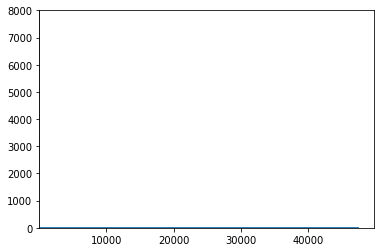

In [11]:

import matplotlib.pyplot as plt

from scipy.io import wavfile
import scipy.signal as signal
import numpy as np

import numpy as np
from scipy import signal
from math import sin, pi
import random
import typing
from scipy.io.wavfile import write





#### Il faut normaliser les spectrogramme et en dB !!


def inverse_spectrogram(f: np.ndarray, t: np.ndarray, Sxx: np.ndarray, fs: int) -> np.ndarray:
    """inverse_spectrogram calculates the inverse spectrogram
from frequencies f, intervals t, magnitude matrix Sxx using the sample rate fs.
Returns signal as a np.array
    """
    #you can not hear the phase they say
    phases = [random.uniform(0,2*pi) for j in range(len(f))]
    #that +1 is here for off by one rounding errors i dont care to chase
    length= int(t[-1]*fs+1)
    #time axis
    out = np.zeros(length)
    for i in range(1,len(t)):
        duration = t[i] - t[i-1]
        start =  t[i-1] * fs
        tics = int(duration*fs)
        for tic in range(tics):
            index = int(start + tic)
            #frequency axis
            for j in range(len(f)):
                magnitude = Sxx[j][i]
                #everyone loves the sin, because it starts from the zero
                out[index] += sin(2*pi/fs*f[j]*index+ phases[j]) * magnitude
    return out
name = "output_0"
path = "../Data/test/Predict/"
spec = np.load(path+name+".npy")

waveform, sample_rate = torchaudio.load("../Data/meme_taille_TEST/sig_1_10.WAV")
spec, f_br, t_br, im_br = plt.specgram(waveform[0].t().numpy(), Fs = sample_rate, NFFT = 512, scale_by_freq = False, mode = 'magnitude', cmap = 'gray', scale='dB')


# spec = 20 * 10*np.log10(spec)


# sig = inverse_spectrogram(f_br, t_br, spec[1,0], sample_rate)
sig = inverse_spectrogram(f_br, t_br, spec, sample_rate)

plt.plot(sig)
# np.shape(spec)
write(path+name+".wav",sample_rate,sig)

In [6]:
plt.imshow(spec)
spec

NameError: name 'spec' is not defined